## ARIMA Model
* It stands for Auto Regression Integrated Moving Average.
* Specified by three ordered parameters (p, d, q)
    * p is the order of autoregressive model (number of time lags)
    * d is the degree of differencing (number of times the data have had past values subtracted)
    * q is the order of moving average model.
    
The ARIMA forecasting for a stationary timeseries is nothing but a linear (regression) equation

### Stationary Time Series
* The mean of the time series should not be a function of time. It should be constant.
* The variance of the time series should not be a function of time.
* The covariance of the ith term and the (i+m)th term should not be a function of time.

<b>Why to make time series stationary?</b>
To make the variables independent, it is said to make time series stationary. Variables can be dependent in mmany ways but can only be independent in one way. So, we will get more information when they are independent.

To make the time series stationary, we need to remove the trend and seasonality from the data.

### Parameter tuning
* Check, if the time series is stationary.
    * Dickey fuller test to check if time series is stationary.
    * It determines how strongly a time series is defined by a trend.
    * The null hypothesis of the test is that the time series is not stationary.
    * The alternate hypothesis is that the time series is stationary.
    
The test results comprise of a Test Statistic and some Critical Values for different confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [1]:
# importing required libraries
import pandas as pd
import numpy as np          # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs 
from datetime import datetime    # To access datetime 
from pandas import Series        # To work on series 
%matplotlib inline              # Plot will be displayed directly below the code cell #no pop up
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")

UsageError: unrecognized arguments: # Plot will be displayed directly below the code cell #no pop up


In [2]:
from sklearn.metrics import mean_squared_error 
from math import sqrt

In [3]:
# read train and test data
train = pd.read_csv("/Data/AV_TSF_Unicorn_JetRail/Train_SU63ISt.csv")
test = pd.read_csv("/Data/AV_TSF_Unicorn_JetRail/Test_0qrQsBZ.csv")

In [4]:
# make a copy of train and test data so that even if we do changes in these dataset we do not lose the original dataset.
train_original=train.copy() 
test_original=test.copy()

In [5]:
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')

In [6]:
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')

In [7]:
for i in (train, test, test_original, train_original):
    i['year'] = i.Datetime.dt.year
    i['month'] = i.Datetime.dt.month
    i['day'] = i.Datetime.dt.day
    i['hour'] = i.Datetime.dt.hour

In [8]:
# Drop ID variable, it has nothing to do with the count
train = train.drop('ID', 1)

# There is a lot of noise in hourly timeseries. Aggregate it to daily, weekly and monthly timeseries.
'''This will reduce noise and make it more stable and easy for the model to learn'''
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 

train = train.resample('D').mean()

C:\Users\Akanksha M\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [9]:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp  

# Converting to daily mean 
test = test.resample('D').mean()

C:\Users\Akanksha M\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [10]:
# Splitting data into training and validation set
'''This is done to check the performance and generalization ability of the model
When working with timeseries, the partition should be done on the basis of time.
Random partition will not work well in this case, as then we may be trying to validate past value based on future'''

# Using time based split
'''If the validation metric(rmse) is changing in proportion to public leaderboard score,
this would imply that we have chosen a stable validation technique.

I am taking last 3 months as validation data and rest as training data. The total duration is of 25 months.

The starting date of the dataset is 25-08-2012 as seen in the exploration part and the end date is 25-09-2014.'''

Train=train.loc['2012-08-25':'2014-06-24']
valid=train.loc['2014-06-25':'2014-09-25']

In [11]:
from statsmodels.tsa.stattools import adfuller 

In [15]:
# Function to calculate the results of Dickey-Fuller test.

def test_stationarity(timeseries):
        #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(24).std()
        #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [13]:
from matplotlib.pylab import rcParams 

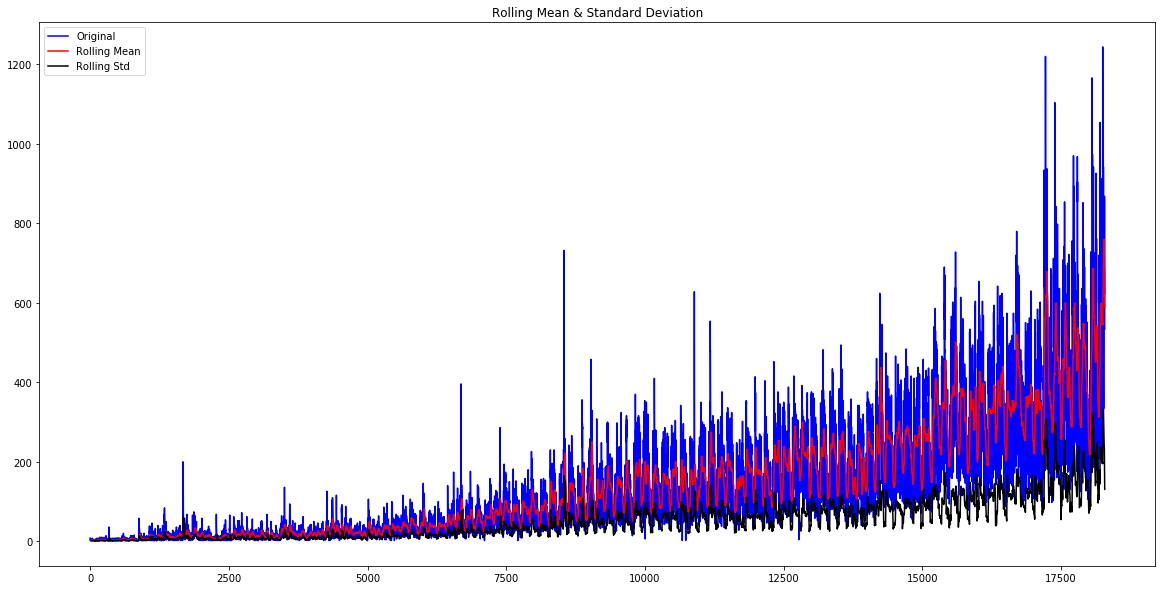

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [16]:
rcParams['figure.figsize'] = 20,10
test_stationarity(train_original['Count'])

Result shows that the 'Test Statistic' < 'Critical Value' so we can reject the null hypothesis, which means the time series is stationary. But we can see the increasing trend in the data from the graph. So, we need to remove it from the data.

### Remove Trend
* It is either increasing or decreasing in data. It doesnot have to be linear.
* For increasing trend, we apply transformation which penalizes higher values more than smaller ones. Eg log transformation
* Here we will use rolling average to remove the trend.

C:\Users\Akanksha M\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


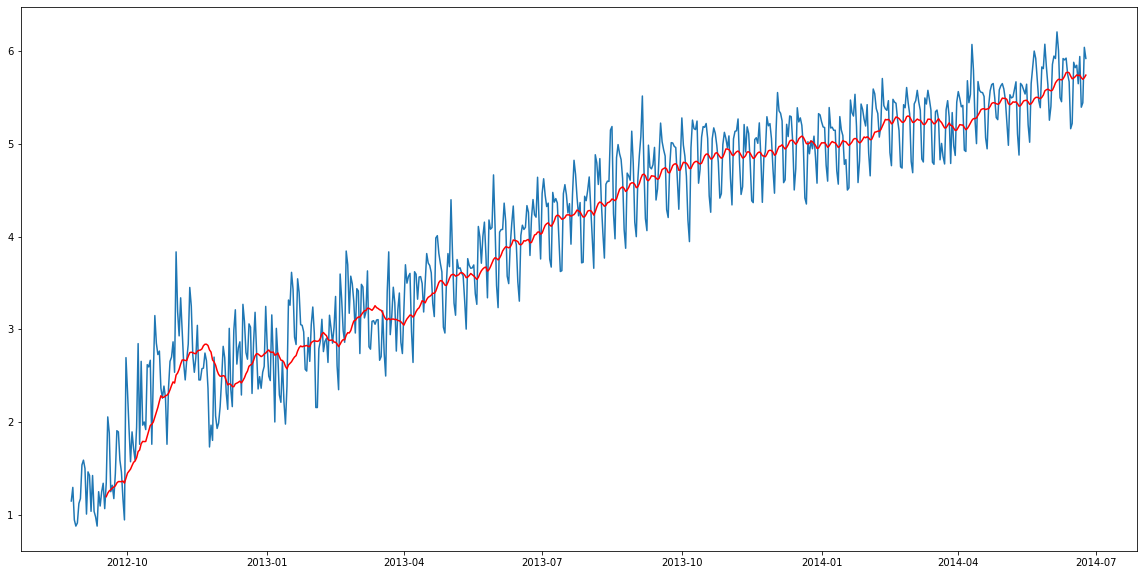

In [17]:
'''We will take the window size of 24 based on the fact that each day has 24 hours.'''

# Apply log transformation
Train_log = np.log(Train['Count']) 
valid_log = np.log(valid['Count'])

# Calculate moving average
moving_avg = Train_log.rolling(24).mean() 

plt.plot(Train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()

In [18]:
# Remove the increasing trend to make our time series stationary.

train_log_moving_avg_diff = Train_log - moving_avg

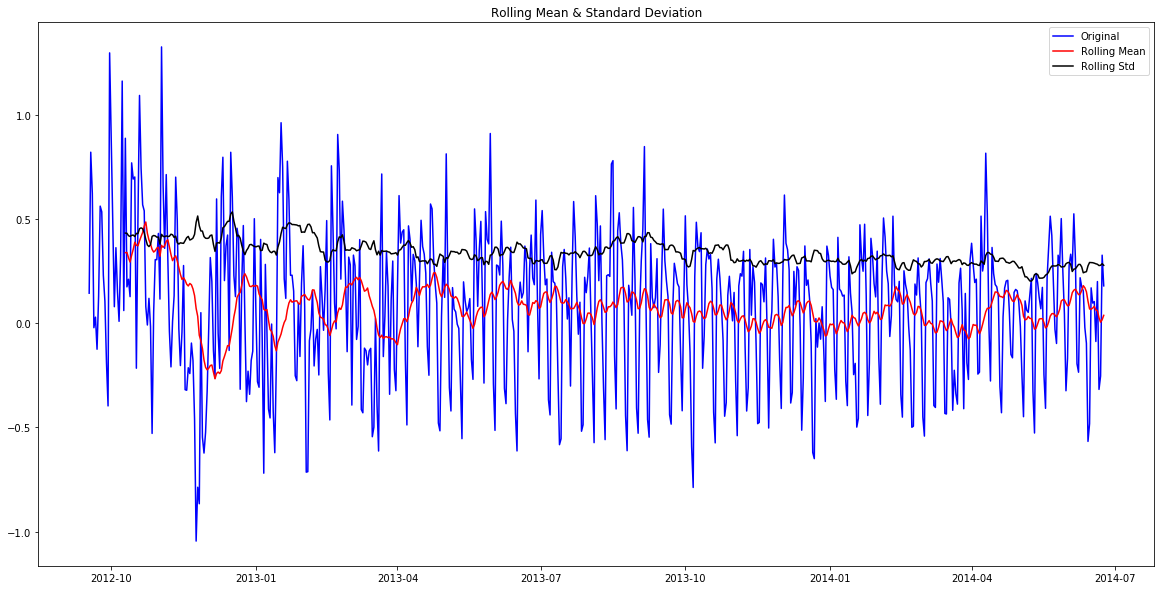

Results of Dickey-Fuller Test:
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [19]:
# Since we took the average of 24 values, rolling mean is not defined for the first 23 values.
# So drop those null values.

train_log_moving_avg_diff.dropna(inplace = True) 
test_stationarity(train_log_moving_avg_diff)

We can see that the Test Statistic is very smaller as compared to the Critical Value. So, we can be confident that the trend is almost removed.

Now stabilize the mean of the time series which is also a requirement for a stationary time series.

Differencing can help to make the series stable and eliminate the trend.

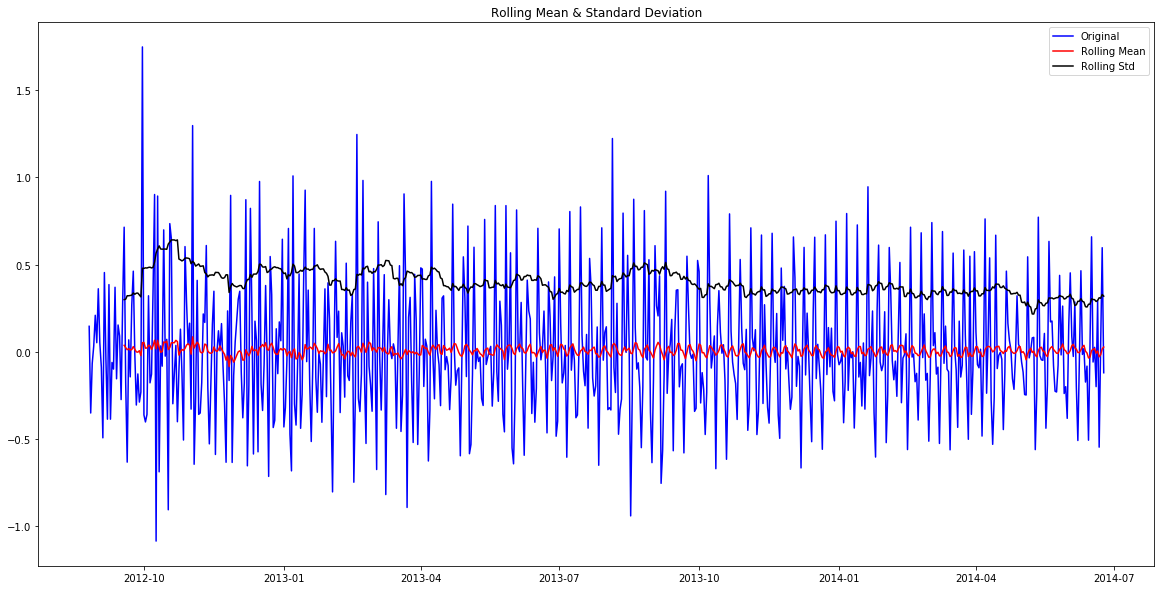

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [20]:
train_log_diff = Train_log - Train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

Now decompose the time series into trend and seasonality and will get the residual which is the random variation in the series.

### Remove Seasonality
* Seasonality means periodic fluctuations, influenced by seasonal factors.
* It is always of a fixed or known period.

In [21]:
# Using seasonal decompose to decompose the time series into trend, seasonality and residuals.

from statsmodels.tsa.seasonal import seasonal_decompose 

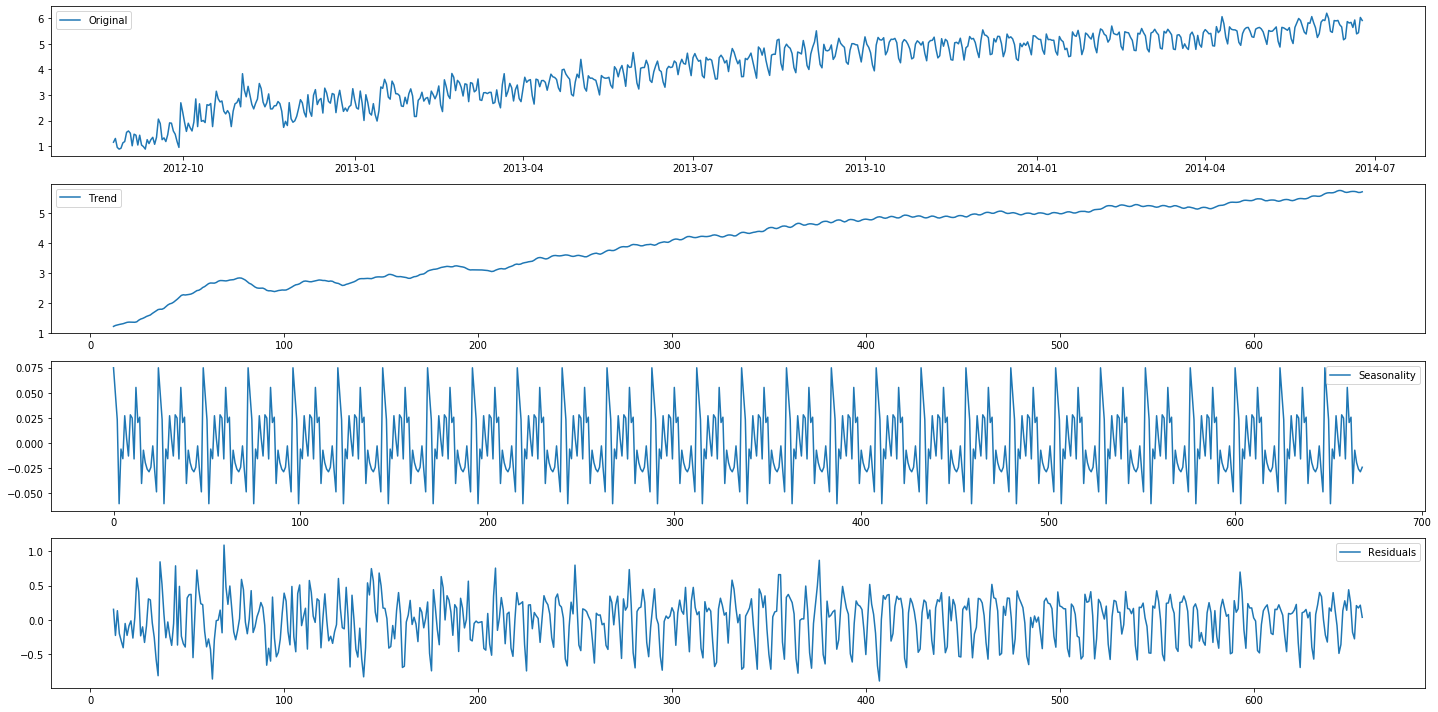

In [22]:
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

plt.subplot(411) 
plt.plot(Train_log, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()

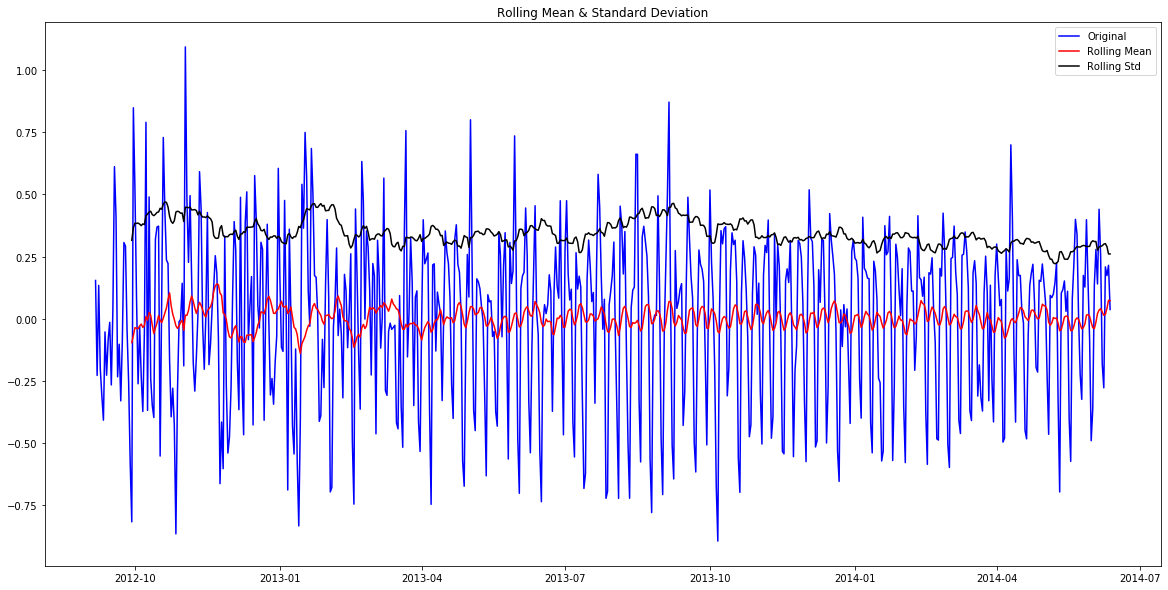

Results of Dickey-Fuller Test:
Test Statistic                -7.822096e+00
p-value                        6.628321e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [23]:
# Check stationarity of residuals.

train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = Train_log.index 
train_log_decompose.set_index('date', inplace = True) 
train_log_decompose.dropna(inplace=True) 
test_stationarity(train_log_decompose[0])

It can be interpreted from the results that the residuals are stationary.

### Forecasting the time series using ARIMA
* Fit the ARIMA model on time series.
* Find the optimized values for the p,d,q parameters.
* To find the optimized values of these parameters, we use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.
    * ACF is a measure of the correlation between the TimeSeries with a lagged version of itself.
    * PACF measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In [24]:
from statsmodels.tsa.stattools import acf, pacf 

In [25]:
lag_acf = acf(train_log_diff.dropna(), nlags=25) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

C:\Users\Akanksha M\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


### ACF and PACF plot
* p value is the lag value where the PACF chart crosses the upper confidence interval for the first time.
* q value is the lag value where the ACF chart crosses the upper confidence interval for the first time.

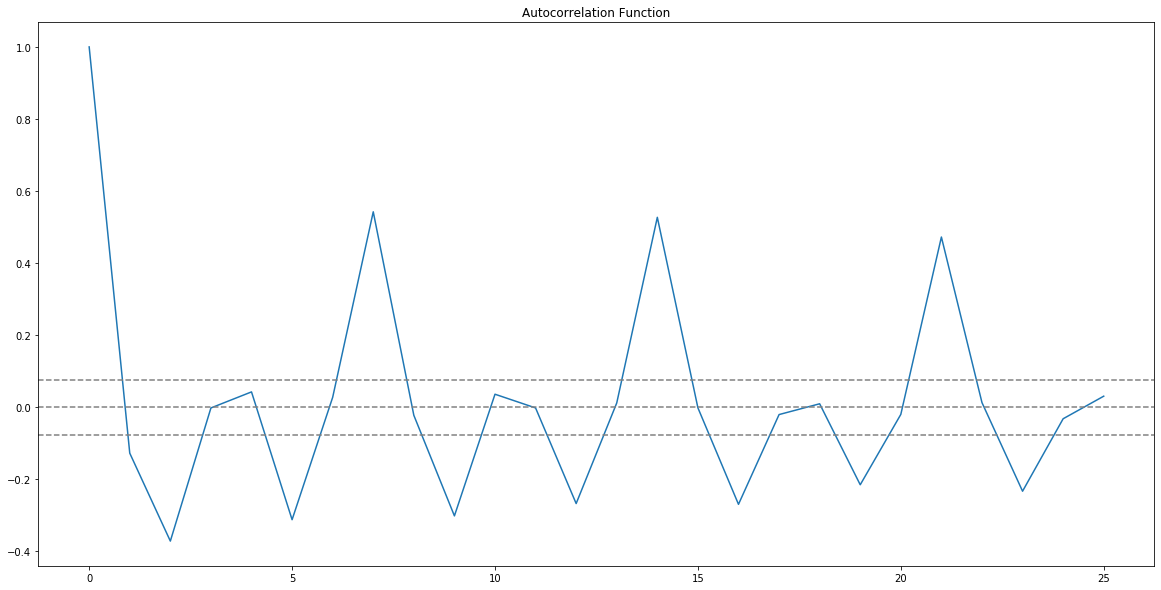

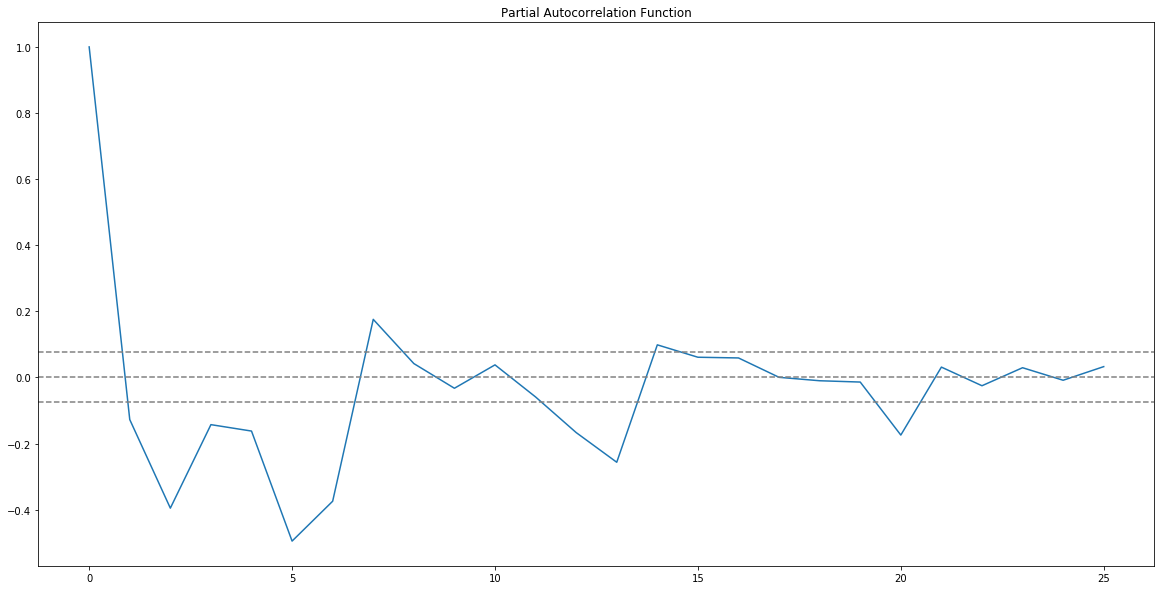

In [26]:
plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') 
plt.show() 

plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()

* It can be noticed that in this case p=1.
* It can be noticed that in this case q=1.

Now we will make the ARIMA model as we have the p,q values. We will make the AR and MA model separately and then combine them together.

#### AR Model
It specifies that the output variable depends linearly on its own previous values.

In [27]:
from statsmodels.tsa.arima_model import ARIMA

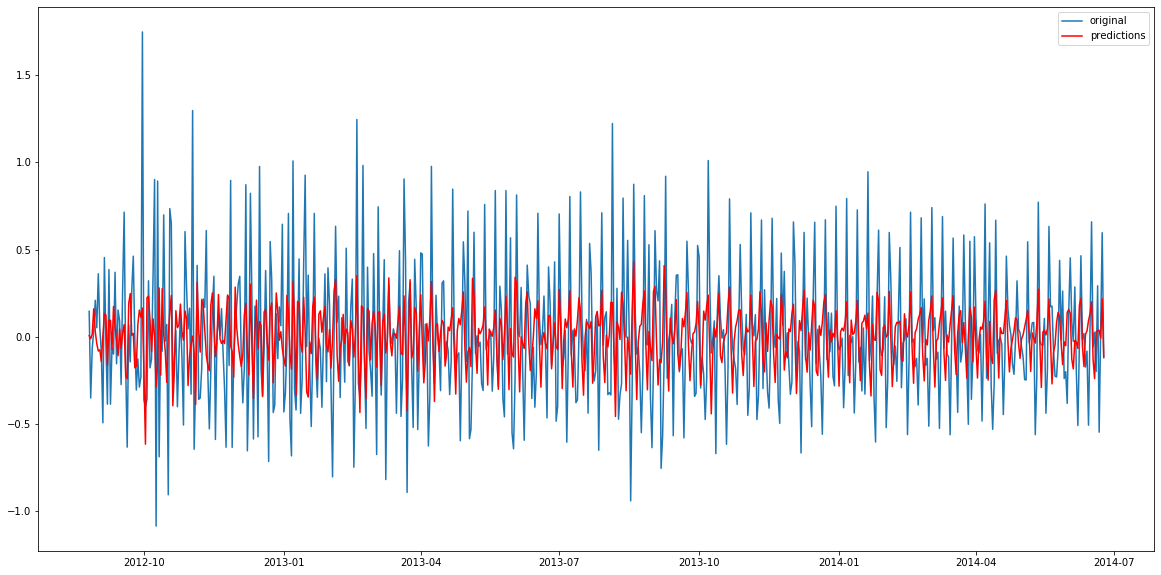

In [28]:
model = ARIMA(Train_log, order=(2, 1, 0))  # here the q value is zero since it is just the AR model 
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.legend(loc='best') 
plt.show()

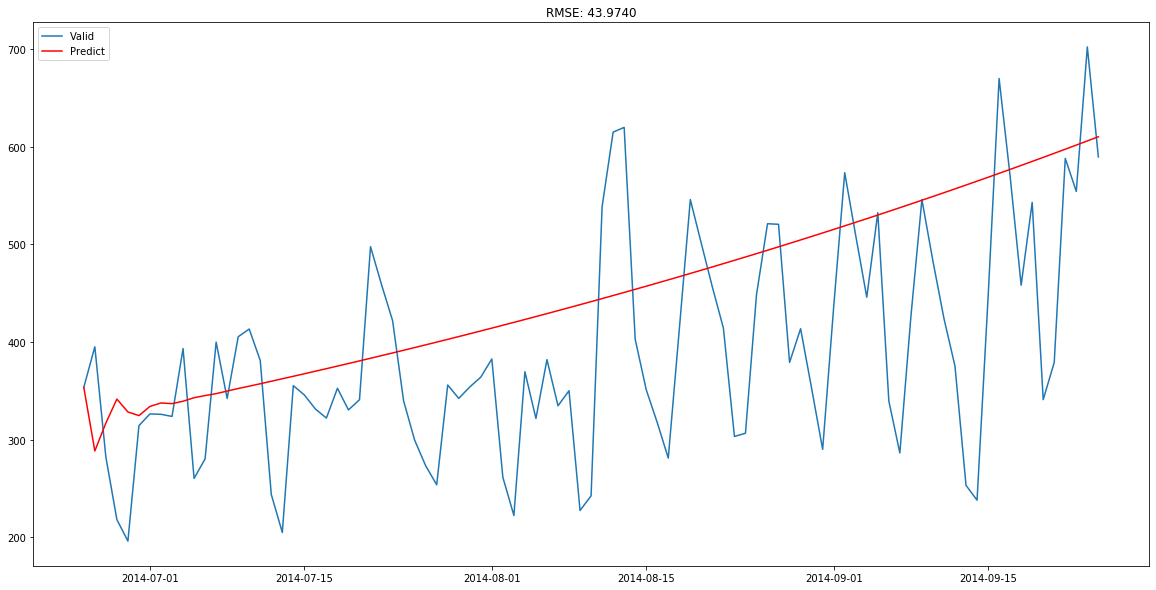

In [29]:
# Plot the validation curve for AR model.
# Change the scale of the model to the original scale.

# Store the predicted results as a separate series and observe it.
AR_predict=results_AR.predict(start="2014-06-25", end="2014-09-25") 
AR_predict=AR_predict.cumsum().shift().fillna(0) 

AR_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index) 
AR_predict1=AR_predict1.add(AR_predict,fill_value=0) 
AR_predict = np.exp(AR_predict1)

plt.plot(valid['Count'], label = "Valid") 
plt.plot(AR_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0])) 
plt.show()

#### MA Model
It specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.

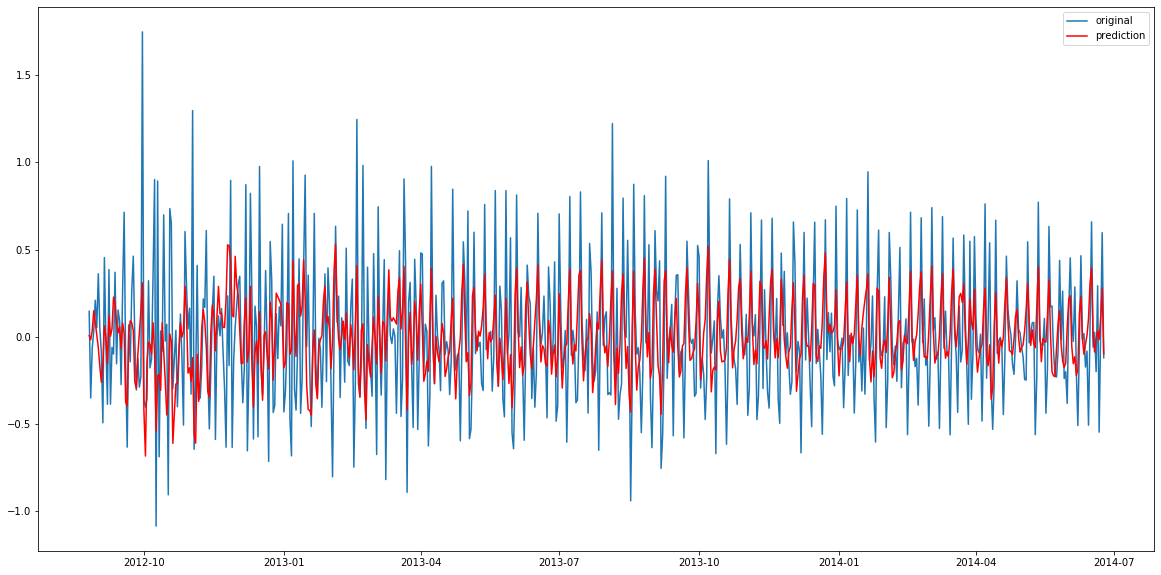

In [30]:
model = ARIMA(Train_log, order=(0, 1, 2))  # here the p value is zero since it is just the MA model 
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_MA.fittedvalues, color='red', label='prediction') 
plt.legend(loc='best') 
plt.show()

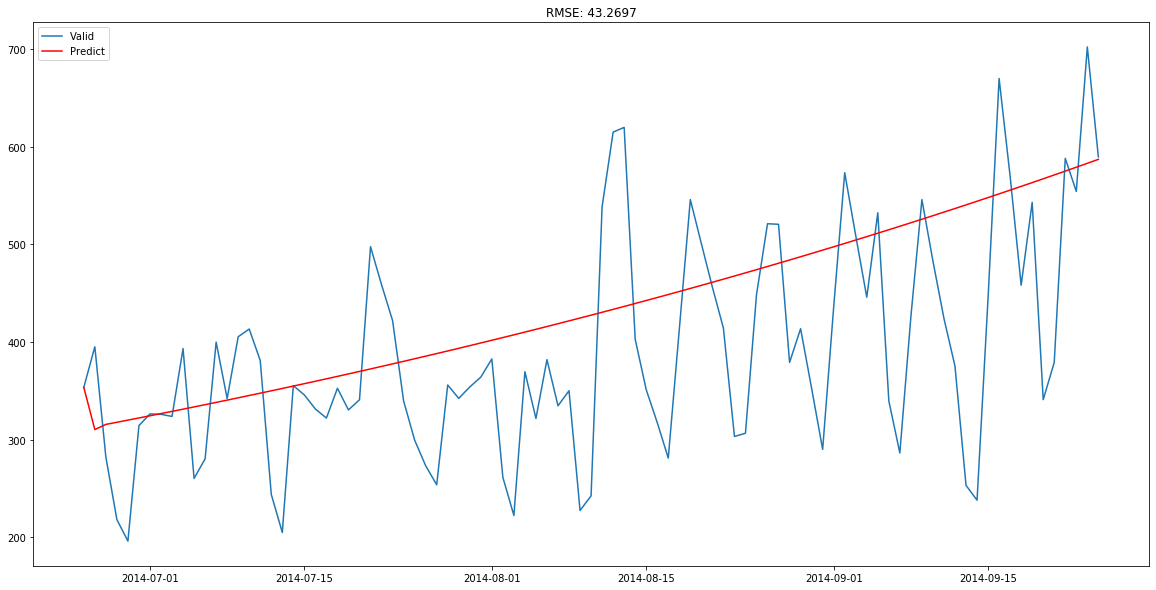

In [31]:
MA_predict=results_MA.predict(start="2014-06-25", end="2014-09-25") 
MA_predict=MA_predict.cumsum().shift().fillna(0) 

MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index) 
MA_predict1=MA_predict1.add(MA_predict,fill_value=0) 
MA_predict = np.exp(MA_predict1)

plt.plot(valid['Count'], label = "Valid") 
plt.plot(MA_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0])) 
plt.show()

#### Combined model

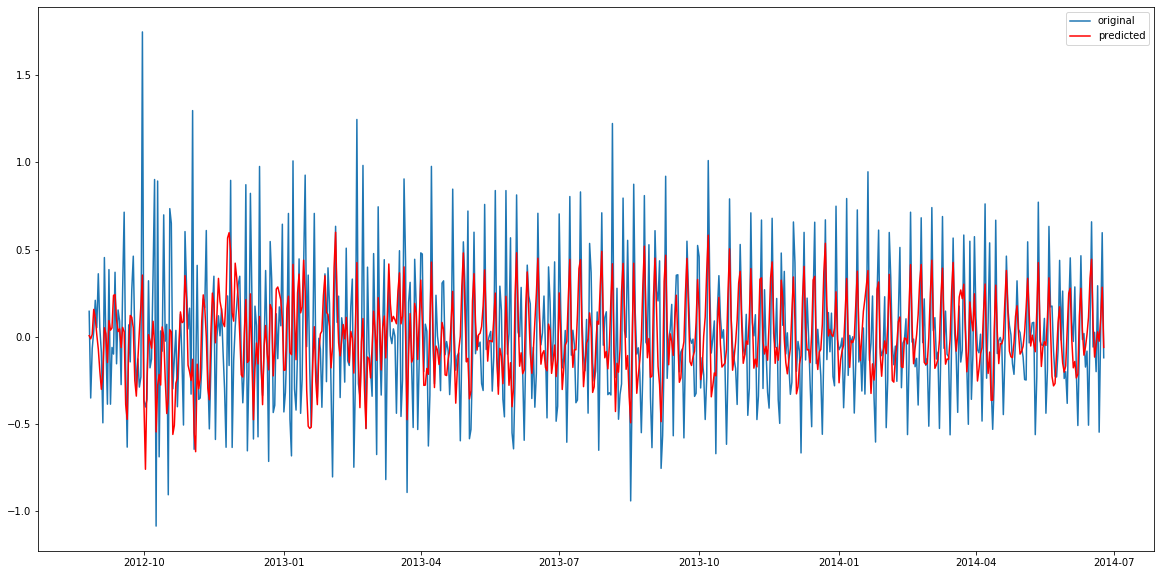

In [32]:
model = ARIMA(Train_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.legend(loc='best') 
plt.show()

In [33]:
# Function to change the scale of the model to the original scale.

def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)

    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
 
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

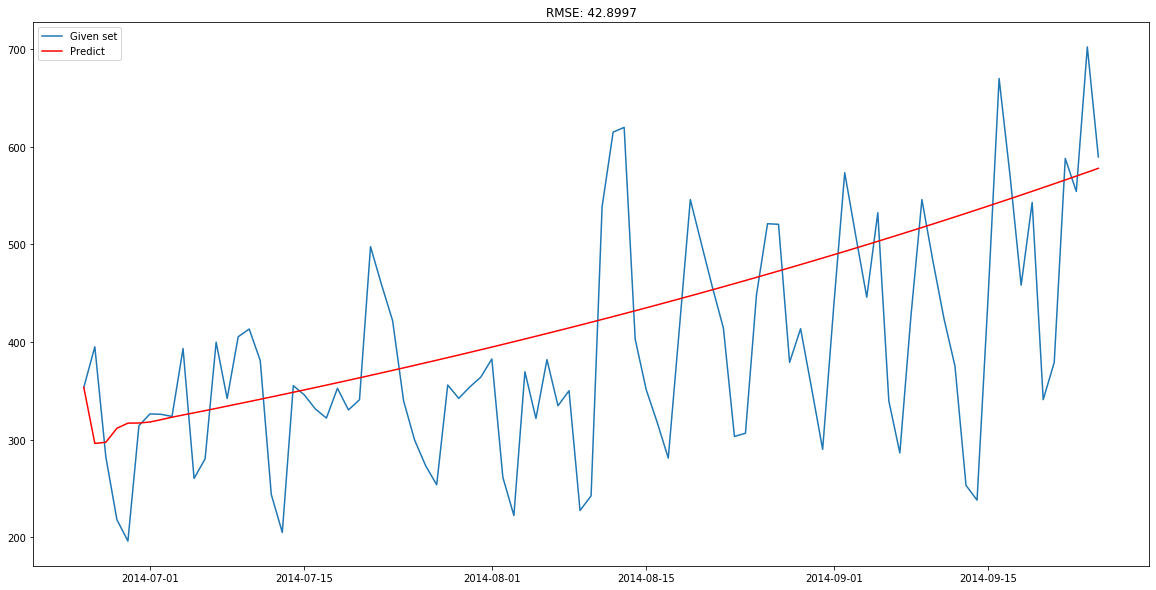

In [34]:
# Predict the values for validation set.

ARIMA_predict_diff=results_ARIMA.predict(start="2014-06-25", end="2014-09-25")
check_prediction_diff(ARIMA_predict_diff, valid)

We can see that RMSE value has been reduced remarkably.

## SARIMAX model
It takes into account the seasonality of the time series.

In [35]:
import statsmodels.api as sm

C:\Users\Akanksha M\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


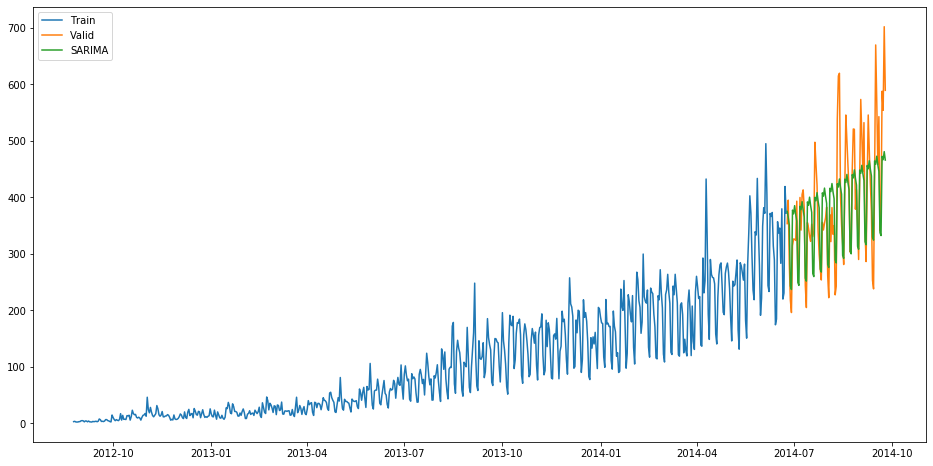

In [36]:
y_hat_avg = valid.copy() 
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit() 
y_hat_avg['SARIMA'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True) 

plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

* Order in the above model represents the order of the autoregressive model(number of time lags), the degree of differencing(number of times the data have had past values subtracted) and the order of moving average model.

* Seasonal order represents the order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.

* In our case the periodicity is 7 since it is daily time series and will repeat after every 7 days.

In [37]:
# Check the rmse value for the validation part.

rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA)) 
print(rms)

69.83622187032599


In [38]:
# Forecast the time series for Test data which starts from 2014-9-26 and ends at 2015-4-26.

predict=fit1.predict(start="2014-9-26", end="2015-4-26", dynamic=True)
test['prediction']=predict

C:\Users\Akanksha M\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


In [39]:
# Convert daily predictions to hourly

# Calculating the hourly ratio of count 
train_original['ratio']=train_original['Count']/train_original['Count'].sum() 

# Grouping the hourly ratio 
temp=train_original.groupby(['hour'])['ratio'].sum() 

# Groupby to csv format 
pd.DataFrame(temp, columns=['hour','ratio']).to_csv('GROUPby.csv') 

temp2=pd.read_csv("GROUPby.csv") 
temp2=temp2.drop('hour.1',1) 

# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['hour']=merge['hour_y'] 
merge=merge.drop(['year', 'month', 'Datetime','hour_x','hour_y'], axis=1) 

# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='hour', how='left') 

# Converting the ratio to the original scale 
prediction['Count']=prediction['prediction']*prediction['ratio']*24

In [ ]:
# Drop all variables other than ID and Count

prediction['ID']=prediction['ID_y'] 
submission=prediction.drop(['day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1) 

# Converting the final submission to csv format 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('SARIMAX.csv')

<b>What else can be tried to improve the model?</b>
* Try weekly predictions and expand it to daily and hourly predictions
* Try combination of models (ensemble) to reduce the RMSE value.